In [4]:
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

## Exploring dataset

In [5]:
dataset = pd.read_csv('../data/HAM10000_metadata.csv')

In [6]:
copy_metadata = dataset.copy()
copy_metadata = copy_metadata.sort_values('image_id')
metadata_slim = copy_metadata[['image_id', 'dx']]
metadata_slim.reset_index(drop=True, inplace=True)
metadata_slim

,image_id,dx
0,ISIC_0024306,nv
1,ISIC_0024307,nv
2,ISIC_0024308,nv
3,ISIC_0024309,nv
4,ISIC_0024310,mel
...,...,...
10010,ISIC_0034316,mel
10011,ISIC_0034317,mel
10012,ISIC_0034318,bkl
10013,ISIC_0034319,nv


In [7]:
label_dict = { 
    'akiec': 0,'bcc': 1,'bkl': 2,'df': 3,'nv': 4,
    'vasc': 5,
    'mel':6
}

In [8]:
metadata_labels = metadata_slim.replace(label_dict)
#pd.get_dummies(metadata_labels

,image_id,dx
0,ISIC_0024306,4
1,ISIC_0024307,4
2,ISIC_0024308,4
3,ISIC_0024309,4
4,ISIC_0024310,6
...,...,...
10010,ISIC_0034316,6
10011,ISIC_0034317,6
10012,ISIC_0034318,2
10013,ISIC_0034319,4


In [9]:
metadata_slim[:1000].dx.value_counts()

nv       685
bkl      111
mel       91
bcc       52
akiec     36
vasc      14
df        11
Name: dx, dtype: int64

## Preprocess one image

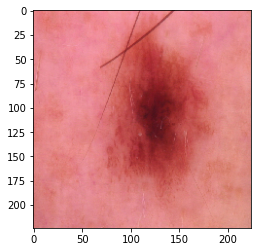

In [10]:
image_one_path = '../data/HAM10000_images_part_1/ISIC_0024306.jpg'
target_size=(224, 224)
original_image = image.load_img(image_one_path, target_size=target_size)
plt.imshow(original_image)

### smart_resize: hitting brick wall on error: output array is read only

In [11]:
# smart_image = image.smart_resize(original_image, target_size)

In [12]:
# work the smart_image to be able to plot it
# def tensor_to_image(tensor):
#     tensor = np.array(tensor, dtype=np.uint8)
#     return PIL.Image.fromarray(tensor)
# smart_image_to_plot = tensor_to_image(smart_image)
# plt.imshow(smart_image_to_plot)

In [13]:
image_array = image.img_to_array(original_image)
img_reshaped = image_array.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))
prepared_image = preprocess_input(img_reshaped)

In [14]:
prepared_image.shape

(1, 224, 224, 3)

## Preprocessing training images

In [21]:
def get_preprocessed_images(images_directory: str, image_size: tuple,limit:int) -> list:
    images = []
    i = 0
    for img in os.listdir(images_directory):
        img = image.load_img(images_directory+img, target_size=image_size)
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        images.append(img)
        i += 1
        if i > limit:
            return np.vstack(images)

In [22]:
image_size =(224,224)
skin_image = get_preprocessed_images("./../data/HAM10000_images_part_1/", image_size, 500)

In [36]:
X = skin_image.copy()
y = metadata_labels.dx[:501]
target = tf.keras.utils.to_categorical(y, num_classes=7, dtype="int")

In [39]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    target,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val,
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

## Import pretrained model

In [40]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [42]:
# Make a model object. Make sure you include the top as well!
model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in model.layers:
    layer.trainable = False

In [43]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(7, activation='softmax'))

# Summarize.
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                6422592   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 29,987,847
Trainable params: 6,423,047
Non-trainable params: 23,564,800
_________________________________________________________________


In [44]:
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
history = new_model.fit(X_train,y_train,
                        epochs=3, 
                        batch_size=20,
                        validation_data=(X_val,y_val)
                       )

Epoch 1/3
16/16 [==============================] - 34s 2s/step - loss: 797.2758 - accuracy: 0.5000 - val_loss: 387.0981 - val_accuracy: 0.5750
Epoch 2/3
16/16 [==============================] - 31s 2s/step - loss: 335.1421 - accuracy: 0.5125 - val_loss: 65.5317 - val_accuracy: 0.5125
Epoch 3/3
16/16 [==============================] - 29s 2s/step - loss: 42.0862 - accuracy: 0.6281 - val_loss: 36.6098 - val_accuracy: 0.6125


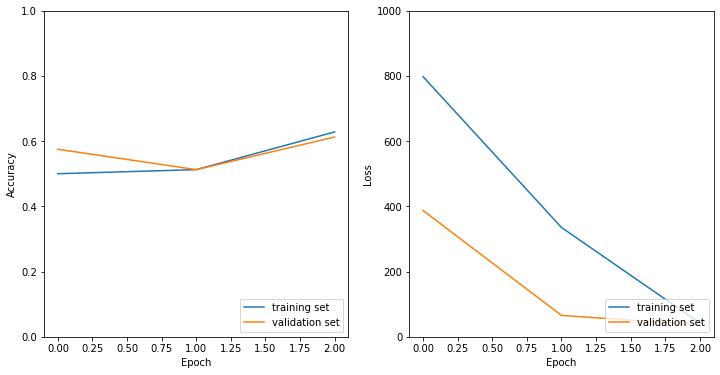

In [54]:
import tensorflow

def plot_history(history : tensorflow.keras.callbacks.History):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 1000])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [55]:
def prepare_image(image_path : str):
    img = image.load_img(image_path,target_size = (224,224))
    img = image.img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    return preprocess_input(img)

In [56]:
def print_score(prediction : list):
    pred = prediction[0][0]
    if pred > 0.7:
        print(f"{round(pred*100,4)}%")
    elif pred < 0.3:
        print(f"{round(pred*100,4)}%")
    else:
        print(f"{round(pred*100,4)}%")

[[0.0000000e+00 4.0580391e-36 5.1095287e-07 1.0743030e-26 9.9999952e-01
  1.0029868e-23 1.2801578e-20]]


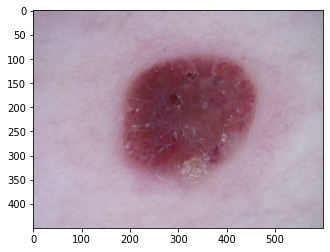

In [61]:
path = "./../data/HAM10000_images_part_2/ISIC_0034318.jpg"
prediction = new_model.predict(prepare_image(path))
print(prediction)
plt.imshow(image.load_img(path))
plt.show()